In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.7 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from transformers import logging
logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *

from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [3]:
from models import *

In [4]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"
input_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/cleaned_dutch_ted1.csv")
translate_back=pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_all.csv")

In [5]:
vc = input_df[label_column].value_counts()
down_sample_vc = vc[vc.values < 1500]
input_df = input_df[input_df[label_column].isin(down_sample_vc.index)]

In [6]:
running_device = torch.device("cuda")

In [7]:
prd = ProcessData(input_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
_,_,_, label_encoder, onehot = prd.process()
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")

After removing duplicate sentence: 16897
After drop cpv with low observations we have : 16803
The num of class is  30
The number of total data is:  15992
Total number of test data is:  900
Total number of train data is:  15092


In [8]:
model_runner = RunModel(running_device)
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)

Getting bert hidden states from layer: 0: 100%|██████████| 900/900 [00:11<00:00, 79.37it/s]


In [9]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [10]:
ACCs = []
F1s = []
Precisions = []
Recalls = []
Label_f1s = []
for i in range(1,9):
  sub_df=translate_back.groupby(label_column, sort=False).sample(frac=float(i/8))
  aug_train_df=pd.concat([sub_df,train_df])
  train_dataset = cd.create(aug_train_df)
  train_dl = DataLoader(train_dataset, shuffle=True, batch_size=20)
  classifier = EmbeddingClassifier(prd.num_class, bert)
  classifier = model_runner.train_classifier(train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  ACCs.append(acc)
  F1s.append(f1)
  Precisions.append(precision)
  Recalls.append(recall)
  Label_f1s.append(label_f1)

100%|██████████| 1132/1132 [01:49<00:00, 10.35it/s]


0 train loss:  3.030622826342869 val acc:  0.35444444848431483


100%|██████████| 1132/1132 [01:49<00:00, 10.37it/s]


1 train loss:  1.7439146669509134 val acc:  0.4788888971010844


100%|██████████| 1132/1132 [01:49<00:00, 10.37it/s]


2 train loss:  1.213695724471719 val acc:  0.5555555688010322


100%|██████████| 1132/1132 [01:49<00:00, 10.37it/s]


3 train loss:  0.9193012809426961 val acc:  0.567777791288164


100%|██████████| 1132/1132 [01:49<00:00, 10.37it/s]


4 train loss:  0.7257352350312598 val acc:  0.5788888990879059


100%|██████████| 1132/1132 [01:49<00:00, 10.37it/s]


5 train loss:  0.5673850234597921 val acc:  0.5877777904272079


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.588
F1: 0.536
Precision: 0.506
Recall: 0.588


100%|██████████| 1510/1510 [02:25<00:00, 10.36it/s]


0 train loss:  2.6653619565711115 val acc:  0.4111111177338494


100%|██████████| 1510/1510 [02:25<00:00, 10.37it/s]


1 train loss:  1.4927256252986705 val acc:  0.5144444551732805


100%|██████████| 1510/1510 [02:25<00:00, 10.37it/s]


2 train loss:  1.083209708382357 val acc:  0.5588889062404633


100%|██████████| 1510/1510 [02:25<00:00, 10.37it/s]


3 train loss:  0.8158280702862913 val acc:  0.6011111252837711


100%|██████████| 1510/1510 [02:25<00:00, 10.37it/s]


4 train loss:  0.6160492037897868 val acc:  0.6155555718474918


100%|██████████| 1510/1510 [02:25<00:00, 10.37it/s]


5 train loss:  0.4693667591333587 val acc:  0.6277777896987067


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.628
F1: 0.583
Precision: 0.585
Recall: 0.628


100%|██████████| 1887/1887 [03:02<00:00, 10.35it/s]


0 train loss:  2.5270773922885357 val acc:  0.41888889571030935


100%|██████████| 1887/1887 [03:02<00:00, 10.36it/s]


1 train loss:  1.384083131949107 val acc:  0.5622222357326083


100%|██████████| 1887/1887 [03:02<00:00, 10.36it/s]


2 train loss:  0.9693428381495711 val acc:  0.6011111232969496


100%|██████████| 1887/1887 [03:02<00:00, 10.36it/s]


3 train loss:  0.7171822808560518 val acc:  0.6100000116560195


100%|██████████| 1887/1887 [03:02<00:00, 10.36it/s]


4 train loss:  0.5385236425545397 val acc:  0.6111111236943139


100%|██████████| 1887/1887 [03:02<00:00, 10.36it/s]


5 train loss:  0.41141488722752073 val acc:  0.6300000137752957


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.583
Precision: 0.556
Recall: 0.630


100%|██████████| 2264/2264 [03:38<00:00, 10.34it/s]


0 train loss:  2.5064602402358087 val acc:  0.43333334194289314


100%|██████████| 2264/2264 [03:39<00:00, 10.33it/s]


1 train loss:  1.4919297690421027 val acc:  0.5011111206478542


100%|██████████| 2264/2264 [03:39<00:00, 10.33it/s]


2 train loss:  1.0879732084727118 val acc:  0.5533333460489909


100%|██████████| 2264/2264 [03:39<00:00, 10.33it/s]


3 train loss:  0.8394491956355347 val acc:  0.5588888996177249


100%|██████████| 2264/2264 [03:38<00:00, 10.35it/s]


4 train loss:  0.6657944416607543 val acc:  0.5577777915530735


100%|██████████| 2264/2264 [03:38<00:00, 10.35it/s]


5 train loss:  0.5527808087209055 val acc:  0.5688889039887323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.569
F1: 0.514
Precision: 0.482
Recall: 0.569


100%|██████████| 2641/2641 [04:15<00:00, 10.35it/s]


0 train loss:  2.233353869678486 val acc:  0.5122222337457869


100%|██████████| 2641/2641 [04:14<00:00, 10.36it/s]


1 train loss:  1.2221858793815308 val acc:  0.5755555689334869


100%|██████████| 2641/2641 [04:14<00:00, 10.36it/s]


2 train loss:  0.8792773276702873 val acc:  0.5866666807068719


100%|██████████| 2641/2641 [04:14<00:00, 10.36it/s]


3 train loss:  0.6428692317280364 val acc:  0.5855555673440297


100%|██████████| 2641/2641 [04:15<00:00, 10.35it/s]


4 train loss:  0.47515103463273933 val acc:  0.6244444529215495


100%|██████████| 2641/2641 [04:14<00:00, 10.36it/s]


5 train loss:  0.3558438443201455 val acc:  0.6500000172191196


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.650
F1: 0.614
Precision: 0.611
Recall: 0.650


100%|██████████| 3019/3019 [04:51<00:00, 10.35it/s]


0 train loss:  2.104930217138147 val acc:  0.5111111217074924


100%|██████████| 3019/3019 [04:52<00:00, 10.34it/s]


1 train loss:  1.1931208414070336 val acc:  0.5622222363948822


100%|██████████| 3019/3019 [04:51<00:00, 10.34it/s]


2 train loss:  0.855173299928776 val acc:  0.5788889017370012


100%|██████████| 3019/3019 [04:52<00:00, 10.32it/s]


3 train loss:  0.6074950843395461 val acc:  0.6066666841506958


100%|██████████| 3019/3019 [04:51<00:00, 10.35it/s]


4 train loss:  0.4399464121264223 val acc:  0.6188888986905415


100%|██████████| 3019/3019 [04:51<00:00, 10.35it/s]


5 train loss:  0.3314094878288937 val acc:  0.6477777904934353


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.615
Precision: 0.606
Recall: 0.648


100%|██████████| 3396/3396 [05:28<00:00, 10.35it/s]


0 train loss:  2.081593709625962 val acc:  0.522222234805425


100%|██████████| 3396/3396 [05:28<00:00, 10.35it/s]


1 train loss:  1.1336876432838092 val acc:  0.5755555682712131


100%|██████████| 3396/3396 [05:28<00:00, 10.35it/s]


2 train loss:  0.7989857858233373 val acc:  0.6377777907583448


100%|██████████| 3396/3396 [05:28<00:00, 10.35it/s]


3 train loss:  0.5463871027971535 val acc:  0.655555565489663


100%|██████████| 3396/3396 [05:28<00:00, 10.35it/s]


4 train loss:  0.3868543190892031 val acc:  0.6655555705229441


100%|██████████| 3396/3396 [05:28<00:00, 10.34it/s]


5 train loss:  0.27317348836816396 val acc:  0.6588888963063558


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.631
Precision: 0.625
Recall: 0.659


100%|██████████| 3773/3773 [06:04<00:00, 10.34it/s]


0 train loss:  2.109954160071165 val acc:  0.5511111226346758


100%|██████████| 3773/3773 [06:04<00:00, 10.35it/s]


1 train loss:  1.0837709213634905 val acc:  0.6022222346729702


100%|██████████| 3773/3773 [06:05<00:00, 10.33it/s]


2 train loss:  0.7362034640053033 val acc:  0.65333334936036


100%|██████████| 3773/3773 [06:05<00:00, 10.34it/s]


3 train loss:  0.5060857627679056 val acc:  0.6533333453867171


100%|██████████| 3773/3773 [06:04<00:00, 10.34it/s]


4 train loss:  0.35603456122649146 val acc:  0.6611111256811354


100%|██████████| 3773/3773 [06:05<00:00, 10.33it/s]


5 train loss:  0.262142444558179 val acc:  0.6555555635028415
Total ACC: 0.656
F1: 0.617
Precision: 0.600
Recall: 0.656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


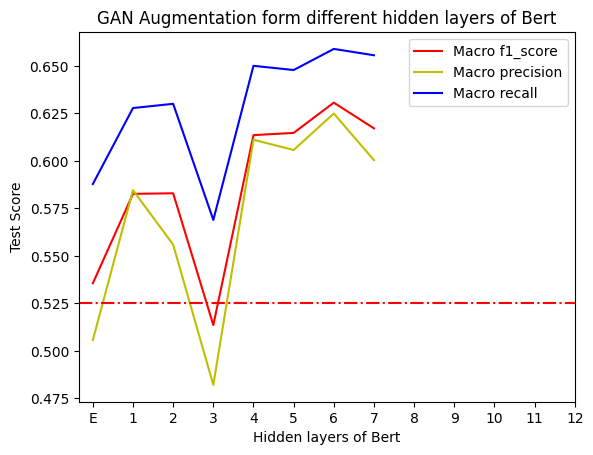

In [11]:
x_label=["E"]+[i for i in range(1,13)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(F1s, label="Macro f1_score",color='r')
plt.plot(Precisions, label="Macro precision",color='y')
plt.plot(Recalls, label="Macro recall",color='b')
plt.axhline(y = 0.525, color = 'r', linestyle = 'dashdot')
plt.xticks([i for i in range(13)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()

In [13]:
value_counts = train_df[label_column].value_counts()
all_fls=np.array(Label_f1s)
for i in range(prd.num_class):
    label=label_encoder.inverse_transform([i])
    print(all_fls[:,i])
    print(value_counts[label])

[0.73529412 0.81355932 0.78125    0.83870968 0.9        0.87096774
 0.89655172 0.78787879]
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen    970
Name: afdeling, dtype: int64
[0.40425532 0.38383838 0.39175258 0.45       0.38202247 0.40909091
 0.46341463 0.44444444]
Bedrijfsmachines    739
Name: afdeling, dtype: int64
[0.63768116 0.71186441 0.85245902 0.         0.80701754 0.81481481
 0.79245283 0.8       ]
Chemische producten    167
Name: afdeling, dtype: int64
[0.61764706 0.74576271 0.70967742 0.         0.64       0.77966102
 0.75409836 0.68852459]
Cultuur-, sport- en recreatiediensten    400
Name: afdeling, dtype: int64
[0.83018868 0.82758621 0.70769231 0.79310345 0.85714286 0.81355932
 0.73015873 0.84615385]
Diensten voor hotel, restaurant en detailhandel    399
Name: afdeling, dtype: int64
[0.78787879 0.76923077 0.8        0.8        0.8        0.78787879
 0.7761194  0.80597015]
Diensten voor onderwijs en opleiding    841
Name: afdeling, dtype: int64
[0.636363

In [14]:
all_fls

array([[0.73529412, 0.40425532, 0.63768116, 0.61764706, 0.83018868,
        0.78787879, 0.63636364, 0.83636364, 0.5974026 , 0.70967742,
        0.        , 0.81967213, 0.51851852, 0.65753425, 0.        ,
        0.        , 0.6440678 , 0.64516129, 0.        , 0.        ,
        0.22222222, 0.71641791, 0.        , 0.75      , 0.89552239,
        0.68852459, 0.44680851, 0.67605634, 0.87878788, 0.71428571],
       [0.81355932, 0.38383838, 0.71186441, 0.74576271, 0.82758621,
        0.76923077, 0.7       , 0.87719298, 0.69565217, 0.70967742,
        0.06451613, 0.83870968, 0.56338028, 0.70422535, 0.        ,
        0.        , 0.72727273, 0.61016949, 0.        , 0.64615385,
        0.46575342, 0.71186441, 0.        , 0.57894737, 0.8125    ,
        0.71186441, 0.54117647, 0.6984127 , 0.84507042, 0.72413793],
       [0.78125   , 0.39175258, 0.85245902, 0.70967742, 0.70769231,
        0.8       , 0.65714286, 0.85714286, 0.69565217, 0.73333333,
        0.        , 0.8852459 , 0.55696203, 0.